In [ ]:
import time
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

# raissi plots
from scipy.interpolate import griddata
from itertools import product, combinations

from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from tqdm import tqdm_notebook as tqdm
import minterpy as mp
from pinnutils import *
from minterpy.derivation import _get_gradient_operator

In [2]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# tuning parameters for experiment
# fig D.1 in paper generated for scales 1-6 and averaged over 5 seeds

scale  = 1 # control frequency of solution omega=scale*pi
method = 0 # 0 - uniform, 1 - inverse-Dirichlet, 2 - max/avg, 3 - MGDA, 4 - optimal
seed   = 1 # rng seed

In [4]:
def Hk_coeff_1d (deg, n_bdy, k_sob):
    Df = (n_bdy[1] - n_bdy[0])/2 
    B = (n_bdy[1] + n_bdy[0])/2 
    mi = mp.multi_index.MultiIndex.from_degree(spatial_dimension=1, poly_degree=deg, lp_degree=np.inf)
    ord_grid =mp.grid.Grid(mi).unisolvent_nodes.T[0]
    un_grid , un_weights = np.polynomial.legendre.leggauss(deg+1)
    ord_index = [[ i for i,j in enumerate(un_grid) if j == ord_grid[k]][0]
                 for k in range(len(ord_grid))]
    scaled_weights = Df * un_weights[ord_index]
    ord_sc_grid = un_grid[ord_index]
    scaled_grid  = ord_sc_grid*Df+B
    lag_poly = mp.LagrangePolynomial(coeffs=None, multi_index=mi)
    can_poly = mp.CanonicalPolynomial(coeffs=None, multi_index=mi)
    c2l_transform = mp.get_transformation(lag_poly, mp.CanonicalPolynomial)
    c2l = c2l_transform.transformation_operator.array_repr_full
    l2c_transform = mp.get_transformation(can_poly, mp.LagrangePolynomial)
    l2c = l2c_transform.transformation_operator.array_repr_full
    Dx = _get_gradient_operator(mi.exponents, c2l, l2c)[0]
    Cx = 1/np.max(abs(Dx))#1/deg**2
    print(Cx)
    Dx_n = Cx*Dx
    return scaled_grid, scaled_weights, Dx, Cx
def H_norm_1d (lag_par,k_sob,res):
        scaled_grid, scaled_weights, Dx, Cx = lag_par
        w_a = torch.tensor(scaled_weights, dtype=torch.float32, device=device)
        L2  = (res**2).dot(w_a)
        Dx = torch.tensor(Dx,dtype=torch.float32, device=device)
        da = torch.mv(Dx,res)
        H = torch.dot(da**2,w_a)
        for i in range(k_sob-1):
            da = torch.mv(Dx,da)
            H+=torch.dot(da**2,w_a)
        return L2, H, Cx

In [5]:

def Hk_coeff_2d (n_bdy, deg,k_sob):
    Df = [(n_bdy[1][i] - n_bdy[0][i])/2 for i in range(len(n_bdy))]
    B = [(n_bdy[1][i] + n_bdy[0][i])/2 for i in range(len(n_bdy))]
    mi = mp.multi_index.MultiIndex.from_degree(spatial_dimension=2, poly_degree=deg, lp_degree=np.inf)
    ord_grid =mp.grid.Grid(mi).unisolvent_nodes
    leg_grid = np.polynomial.legendre.leggauss(deg+1)[0]
    leg_weights = np.polynomial.legendre.leggauss(deg+1)[1]
    X_1,X_2 = np.meshgrid(leg_grid,leg_grid)
    X_1 = X_1.reshape((deg+1)*(deg+1))
    X_2 = X_2.reshape((deg+1)*(deg+1))
    un_grid = np.concatenate((np.array([X_1]).T,np.array([X_2]).T),axis=1)
    un_weights = np.outer(leg_weights, leg_weights).reshape((deg+1)*(deg+1))
    ord_index = [[ i for i,j in enumerate(un_grid) if j[0] == ord_grid[k][0] and 
                     j[1] == ord_grid[k][1]][0] for k in range(len(ord_grid))]
    scaled_weights = Df[0]*Df[1]*un_weights[ord_index]
    ord_sc_grid = un_grid[ord_index]
    scaled_grid  = np.concatenate(([ord_sc_grid[:,0]*Df[0]+B[0]],
                                   [ord_sc_grid[:,1]*Df[1]+B[1]]),axis=0)
    lag_poly = mp.LagrangePolynomial(coeffs=None, multi_index=mi)
    can_poly = mp.CanonicalPolynomial(coeffs=None, multi_index=mi)
    c2l_transform = mp.get_transformation(lag_poly, mp.CanonicalPolynomial)
    c2l = c2l_transform.transformation_operator.array_repr_full
    l2c_transform = mp.get_transformation(can_poly, mp.LagrangePolynomial)
    l2c = l2c_transform.transformation_operator.array_repr_full
    Dx =_get_gradient_operator(mi.exponents, c2l, l2c)
    Cx = 1/np.max(abs(Dx))#1/deg**2
    print(Cx)
    Dx_n = Cx*_get_gradient_operator(mi.exponents, c2l, l2c)
    return scaled_grid, scaled_weights, Dx, Cx
def H_norm_2d (lag_par,k_sob, res):
    scaled_grid, scaled_weights, Dx, Cx = lag_par
    w_a = torch.tensor(scaled_weights, dtype=torch.float32, device=device)
    L2 = (res**2).dot(w_a)
    H1, D1, H2, D2, H3, D3, H4, D4 = [[],[],[],[],[],[],[],[]]
    H1=H2=H3=H4 = 0
    if k_sob == 1 or k_sob == 2 or k_sob ==3 or k_sob==4:
        D = [torch.tensor(Dx[0],dtype=torch.float32, device=device),torch.tensor(Dx[1],dtype=torch.float32, device=device)]
        for i in [0,1]:
            Df = torch.mv(D[i],res)
            D1.append(Df)
            H1+=torch.dot(Df**2,w_a)
        if k_sob == 2 or k_sob ==3 or k_sob==4:
            for ind in [[0,0],[0,1],[1,1]]:
                Df = torch.mv(D[ind[0]],D1[ind[1]])
                D2.append(Df)
                H2+=torch.dot(Df**2,w_a)
            if k_sob ==3 or k_sob==4:
                for ind in [[0,0],[0,1],[0,2],[1,2]]:
                    Df = torch.mv(D[ind[0]],D2[ind[1]])
                    D3.append(Df)
                    H3+=torch.dot(Df**2,w_a)
                if k_sob==4:
                    for ind in [[0,0],[0,1],[0,2],[0,3],[1,3]]:
                        Df = torch.mv(D[ind[0]],D3[ind[1]])
                        D4.append(Df)
                        H4+=torch.dot(Df**2,w_a)
    return L2,torch.Tensor([H1,H2,H3,H4]),Cx

In [15]:
deg_1d = 25
n_bdy_1d = np.array([-1,1])
k_s_bdy = 4
xb_s, w_b, D_b, Cb  = Hk_coeff_1d(deg_1d, n_bdy_1d,k_s_bdy)
deg_2d = 25
k_s_ini = 1
k_s_res = 2
n_bdy_2d = np.array([[-1.0, -1.0],[1.0, 1.0]])
Xi_s, w_i, D_i, Ci = Hk_coeff_2d (n_bdy_2d, deg_2d,k_s_ini)
Xr_s, w_r, D_r, Cr = Hk_coeff_2d (n_bdy_2d, deg_2d,k_s_res)

/home/suarez08/PhD_PINNs/minterpy/transformation_operators.py:37: UserWarning: building a full transformation matrix from a barycentric transformation. this is inefficient.
  warn('building a full transformation matrix from a barycentric transformation. this is inefficient.')


0.00504118108130804
0.0012415846533744774
0.0012415846533744774


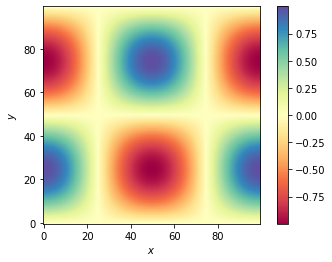

In [16]:
# setup training data and ground truth
def poisson_equation(x,y,omega):
    return np.cos(omega*x)*np.sin(omega*y)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
scale = 1
sob_s = len(xb_s)
omega = scale*np.pi
xx,yy = np.meshgrid(x,y)
u_sol = poisson_equation(xx,yy,omega)
u_sol_s = poisson_equation(Xr_s[:,0],Xr_s[:,1],omega)
X = np.vstack([xx.ravel(), yy.ravel()]).T
xb = np.linspace(-1,1,100)
yb = np.linspace(-1,1,100)
# X boundaries
lb   = np.min(xb)*np.ones((yb.shape))
lbs   = np.min(xb_s)*np.ones((xb_s.shape))
Xlb  = np.vstack((lb,yb)).T
Xlbs  = np.vstack((lbs,xb_s)).T
UXlb = np.cos(omega*Xlb[:,0])*np.sin(omega*Xlb[:,1])
UXlbs = np.cos(omega*Xlbs[:,0])*np.sin(omega*Xlbs[:,1])

rb   = np.max(xb)*np.ones((yb.shape))
rbs   = np.max(xb_s)*np.ones((xb_s.shape))
Xrb  = np.vstack((rb,yb)).T
Xrbs  = np.vstack((rbs,xb_s)).T
UXrb = np.cos(omega*Xrb[:,0])*np.sin(omega*Xrb[:,1])
UXrbs = np.cos(omega*Xrbs[:,0])*np.sin(omega*Xrbs[:,1])
    
# Y boundaries
lb   = np.min(yb)*np.ones((xb.shape))
lbs   = np.min(xb_s)*np.ones((xb_s.shape))
Ylb  = np.vstack((xb,lb)).T
UYlb = np.cos(omega*Ylb[:,0])*np.sin(omega*Ylb[:,1])
Ylbs  = np.vstack((xb_s,lbs)).T
UYlbs = np.cos(omega*Ylbs[:,0])*np.sin(omega*Ylbs[:,1])
    
rb   = np.max(yb)*np.ones((xb.shape))
rbs   = np.max(xb_s)*np.ones((xb_s.shape))
Yrb  = np.vstack((xb,rb)).T
UYrb = np.cos(omega*Yrb[:,0])*np.sin(omega*Yrb[:,1])
Yrbs  = np.vstack((xb_s,rbs)).T
UYrbs = np.cos(omega*Yrbs[:,0])*np.sin(omega*Yrbs[:,1])
##Inverse problem data
U_gt = poisson_equation(X[:,0],X[:,1],omega)
U_gts = poisson_equation(Xr_s[0],Xr_s[1],omega)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.xticks(np.arange(-1,len(x)+1,25), np.arange(-1, 1.1, 0.25))
#plt.yticks(np.arange(-1,len(y)+1,25), np.arange(-1, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()

In [17]:
len(UXrbs)

26

In [18]:
#### np.random.seed(seed)
torch.manual_seed(seed)
# initialize training tensors
idxs = np.random.choice(len(X), len(Xr_s.T), replace=False)
X_train = torch.tensor(X[idxs], dtype=torch.float32, requires_grad=True, device=device)
X_train_s = torch.tensor(Xr_s.T, dtype=torch.float32, requires_grad=True, device=device)
X_ip = torch.tensor(X[idxs], dtype=torch.float32, device=device)
X_ip_s = torch.tensor(Xr_s.T, dtype=torch.float32, device=device)
X_rb = torch.tensor(Xrb, dtype=torch.float32, device=device)
X_lb = torch.tensor(Xlb, dtype=torch.float32, device=device)
X_rbs = torch.tensor(Xrbs, dtype=torch.float32, device=device)
X_lbs = torch.tensor(Xlbs, dtype=torch.float32, device=device)

Y_rb = torch.tensor(Yrb, dtype=torch.float32, device=device)
Y_lb = torch.tensor(Ylb, dtype=torch.float32, device=device)
Y_rbs = torch.tensor(Yrbs, dtype=torch.float32, device=device)
Y_lbs = torch.tensor(Ylbs, dtype=torch.float32, device=device)

U_X_rb = torch.tensor(UXrb, dtype=torch.float32, device=device).reshape(100,1)
U_X_lb = torch.tensor(UXlb, dtype=torch.float32, device=device).reshape(100,1)
U_Y_rb = torch.tensor(UYrb, dtype=torch.float32, device=device).reshape(100,1)
U_Y_lb = torch.tensor(UYlb, dtype=torch.float32, device=device).reshape(100,1)
U_X_rbs = torch.tensor(UXrbs, dtype=torch.float32, device=device)
U_X_lbs = torch.tensor(UXlbs, dtype=torch.float32, device=device)
U_Y_rbs = torch.tensor(UYrbs, dtype=torch.float32, device=device)
U_Y_lbs = torch.tensor(UYlbs, dtype=torch.float32, device=device)

##Inverse Problem 
U_gt = torch.tensor(U_gt[idxs], dtype=torch.float32, device=device)
U_gts = torch.tensor(U_gts, dtype=torch.float32, device=device)

TD = np.concatenate([X[idxs], Xrb, Xlb, Yrb, Ylb], 0)
TDs = np.concatenate([Xr_s.T, Xrbs, Xlbs, Yrbs, Ylbs], 0)

# compute mean and std of training data
X_mean = torch.tensor(np.mean(TD, axis=0, keepdims=True), dtype=torch.float32, device=device)
X_std  = torch.tensor(np.std(TD, axis=0, keepdims=True), dtype=torch.float32, device=device)
X_means = torch.tensor(np.mean(TDs, axis=0, keepdims=True), dtype=torch.float32, device=device)
X_stds  = torch.tensor(np.std(TDs, axis=0, keepdims=True), dtype=torch.float32, device=device)

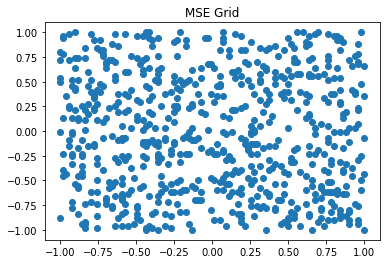

In [19]:
plt.scatter(X[idxs][:,0],X[idxs][:,1])
plt.title('MSE Grid')
plt.show()

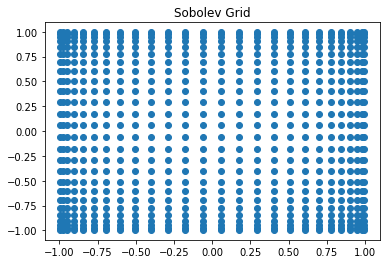

In [20]:
plt.scatter(Xr_s[0],Xr_s[1])
plt.title('Sobolev Grid')
plt.show()

In [21]:
def poisson_residual(uhat, data, omega):
    poly = torch.ones_like(uhat)
    
    du = grad(outputs=uhat, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
    
    dudx = du[:,0:1]
    dudy = du[:,1:2]
    
    dudxx = grad(outputs=dudx, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,0:1]
    dudyy = grad(outputs=dudy, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,1:2]
    
    xin = data[:,0:1]
    yin = data[:,1:2]
    
    source = -2.0*omega*omega*torch.cos(omega*xin)*torch.sin(omega*yin) + 0*uhat
    
    residual = dudxx + dudyy - source
                
    return residual

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
method= 1
net = PINN(sizes=[2,50,50,50,50,50,1], mean=X_mean, std=X_std, seed=seed, activation=torch.nn.ELU()).to(device)
print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))

n_epochs   = 10000
lamb       = 3
alpha_ann  = 0.5
mm         = 5

# logging
losses_bc  = []
losses_reg = []
lambs      = []

params = [{'params': net.parameters(), 'lr': 1e-3}]

optimizer = Adam(params)
scheduler = MultiStepLR(optimizer, [10000,20000,30000], gamma=0.1)

print("training with shape", X_train.size())
L_l2 = []
L_inf =[]
L_inf_pde = []
start = time.time()
for epoch in range(n_epochs):
    net.train()
    optimizer.zero_grad()
    #Residual Loss
    uhat  = net(X_train)
    res   = poisson_residual(uhat, X_train, omega)
    l_reg = torch.mean((res)**2)
    #Initial Loss 
    uhat_ini  = net(X_ip)
    res_ini   = uhat_ini.T[0]-U_gt
    l_ini = torch.mean((res_ini)**2)
    #
    stdr  = 0
    maxr  = 0
    G_reg = 0
    with torch.no_grad():
        if epoch % mm == 0:
            if method == 1:
                stdr = loss_grad_std(l_reg, net)
            if method == 2:
                maxr, _ = loss_grad_max(l_reg, net)
            if method == 3:
                G_reg = network_gradient(l_reg, net)
                
    predl = net(X_lb)
    predr = net(X_rb)
    l_bc  = torch.mean((predl - U_X_lb)**2, dim=0)
    l_bc += torch.mean((predr - U_X_rb)**2, dim=0)
 
    predl = net(Y_lb)
    predr = net(Y_rb)
    l_bc += torch.mean((predl - U_Y_lb)**2, dim=0)
    l_bc += torch.mean((predr - U_Y_rb)**2, dim=0)
    
    with torch.no_grad():
        if epoch % mm == 0:
            if method == 1:
                # inverse-dirichlet
                stdb = loss_grad_std(l_bc, net)

                lamb_hat = stdr/stdb
                lamb     = (1-alpha_ann)*lamb + alpha_ann*lamb_hat
                lambs.append(lamb.item())
            elif method == 2:
                # max/avg
                _, meanu = loss_grad_max(l_bc, net, lambg=lamb)  
                
                lamb_hat = maxr/meanu
                lamb     = (1-alpha_ann)*lamb + alpha_ann*lamb_hat
                lambs.append(lamb.item()) 
            elif method == 3:
                # mgda
                G_bc = network_gradient(l_bc, net)
                
                M = torch.zeros((torch.numel(G_reg), 2), dtype=torch.float32, device=device)
                M[:,0] = G_reg
                M[:,1] = G_bc
                        
                c_ = solver_mine(torch.matmul(M.T, M).cpu().numpy(), 2, 1e-6, maxiter=1000)
                lambs.append([c_[0].item(), c_[1].item()])
            elif method == 4:
                # optimal
                lamb = 1.0/(1.0 + omega**4)
            else:
                # uniform
                lamb = 1
                
    if method == 1 or method == 2:
        loss = l_reg + lamb*l_bc
    elif method == 3:
        loss = c_[0]*l_reg + c_[1]*l_bc
    elif method == 4:
        loss = lamb*l_reg + (1.0 - lamb)*l_bc
    else:
        loss = l_reg + l_bc
    L_inf_pde.append(torch.max(abs(res)))
    L_l2.append(loss)
    L_inf.append(torch.max(abs(res_ini)))
    losses_bc.append(l_bc.item())
    losses_reg.append(l_reg.item())
    
    loss.backward()

    optimizer.step()
    scheduler.step()
    
    if epoch % 1 == 0:
        print("epoch {}/{}, loss={:.7f}, lambda={:.4f}\t\t\t"
          .format(epoch+1, n_epochs, loss.item(), lamb), end="\r")

#    # save model   
#    if epoch % 5000 == 0:
#        torch.save(net, './models/poisson_meth' + str(method) + '_scale' + str(scale) + '_5L' + '_N2500' + '_ep' + str(epoch)  + '_' + "tanh" + "_seed"+ str(seed) + '.pth')
#        
#        mdict = {
#           "epoch": epoch,
#           "t": (time.time() - start),
#           "l_bc":  losses_bc,
#           "l_reg": losses_reg,
#           "lamb": lambs
#        }
#
#        sio.savemat("./results/poisson_param_track_N2500_scale{}_method{}_seed{}".format(scale, method, seed), mdict)

elapsed_time = time.time() - start
print('CPU time =', elapsed_time)

In [ ]:
folder = r'/home/suarez08/PhD_PINNs/Results_Simulation/D_30.07/'+'_'+str(method)
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
xx,yy = np.meshgrid(x,y)
u_sol = poisson_equation(xx,yy,omega)
u_sol_s = poisson_equation(Xr_s[:,0],Xr_s[:,1],omega)
X = np.vstack([xx.ravel(), yy.ravel()]).T

inp = torch.tensor(X, dtype=torch.float32, device=device)
out = net(inp).cpu().data.numpy().reshape(u_sol.shape)

print("pred rel. lin-error = {:e}".format(np.max(abs(out.reshape(-1)-u_sol.reshape(-1)))))
print("pred rel. l2-error = {:e}".format(np.mean(abs(out.reshape(-1)-u_sol.reshape(-1)))))
plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol)/np.max(np.abs(u_sol)), cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error $L_{\infty}=$"+str(np.max(abs(out.reshape(-1)-u_sol.reshape(-1))))+' L_{2}='+str(np.mean(abs(out.reshape(-1)-u_sol.reshape(-1)))))
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig(folder + 'Error_MSE.png')
plt.gcf().set_size_inches(14,4)
plt.tight_layout()

In [22]:
np.random.seed(seed)
torch.manual_seed(seed)
method = 0

net_s = PINN(sizes=[2,50,50,50,50,50,1], mean=X_means, std=X_stds, seed=seed, activation=torch.nn.ELU()).to(device)
print("#parameters:", sum(p.numel() for p in net_s.parameters() if p.requires_grad))

n_epochs   = 5000
lamb       = 1
alpha_ann  = 0.5
mm         = 5

# logging
losses_bc_s  = []
losses_reg_s = []
lambs_s      = []

params_s = [{'params': net_s.parameters(), 'lr': 1e-3}]

optimizer = Adam(params_s)
scheduler = MultiStepLR(optimizer, [10000,20000,30000], gamma=0.1)

print("training with shape", X_ip_s.size())
L_hk = []
L_infs = []
L_inf_pdes = []
start = time.time()
for epoch in range(n_epochs):
    net_s.train()
    optimizer.zero_grad()
    uhat  = net_s(X_train_s)
    res   = poisson_residual(uhat, X_train_s, omega).T[0]
    ##Sobolev residual loss
    
    L2_r, Hk_r, Cr = H_norm_2d([Xr_s, w_r, D_r, Cr],k_s_res,res)
    l_reg_s = L2_r + torch.sum(Hk_r)
    # Initial Loss 
    uhat_ini  = net_s(X_ip_s)
    res_ini   = uhat_ini.T[0]-U_gts#poisson_residual(uhat, X_train_s, omega).T[0]
    ##Sobolev residual loss
    L2_i, Hk_i, Ci = H_norm_2d([Xi_s, w_i, D_i, Ci],k_s_ini,res_ini)
    l_ini_s = L2_i + torch.sum(Hk_i)
    stdr  = 0
    maxr  = 0
    G_reg = 0
    with torch.no_grad():
        if epoch % mm == 0:
            if method == 1:
                stdr = loss_grad_std(l_reg_s, net_s)
            if method == 2:
                maxr, _ = loss_grad_max(l_reg_s, net_s)
            if method == 3:
                G_reg = network_gradient(l_reg_s, net_s)
                
    #Boundary Loss X boundary fixed Y
    predlx = net_s(X_lbs)
    predrx = net_s(X_rbs)
    res_lbx = (predlx - U_X_lbs).T[0]
    res_rbx = (predrx - U_X_rbs).T[0]
    L2_xl, Hk_xl, Cb = H_norm_1d ([xb_s, w_b, D_b, Cb],k_s_bdy,res_lbx)
    L2_xr, Hk_xr, Cb = H_norm_1d ([xb_s, w_b, D_b, Cb],k_s_bdy,res_rbx)
    Lb_x = L2_xl+L2_xr+Hk_xl+Hk_xr
    #Boundary Loss Y boundary fixed X
    predly = net_s(Y_lbs)
    predry = net_s(Y_rbs)
    res_lby = (predly - U_Y_lbs).T[0]
    res_rby = (predry - U_Y_rbs).T[0]
    L2_yl, Hk_yl, Cb = H_norm_1d ([xb_s, w_b, D_b, Cb],k_s_bdy,res_lby)
    L2_yr, Hk_yr, Cb = H_norm_1d ([xb_s, w_b, D_b, Cb],k_s_bdy,res_rby)
    Lb_y = L2_yl+L2_yr+Hk_yl+Hk_yr
    #L2_ip_by = (res_lby**2).dot(torch.tensor(w_b,dtype=torch.float32, device=device))
    #L2_ip_by += (res_rby**2).dot(torch.tensor(w_b,dtype=torch.float32, device=device))
    #cxc_lby = torch.outer(res_lby,res_lby)
    #cxc_rby = torch.outer(res_rby,res_rby)
    #H_k_by = np.sum([torch.sum(cxc_lby*torch.tensor(wh_b[i],dtype=torch.float32, device=device)) for i in range(len(wh_b))])
    #H_k_by += np.sum([torch.sum(cxc_rby*torch.tensor(wh_b[i],dtype=torch.float32, device=device)) for i in range(len(wh_b))])
    l_bc_s =  Lb_x + Lb_y
    with torch.no_grad():
        if epoch % mm == 0:
            if method == 1:
                # inverse-dirichlet
                stdb = loss_grad_std(l_bc, net)

                lamb_hat = stdr/stdb
                lamb     = (1-alpha_ann)*lamb + alpha_ann*lamb_hat
                lambs.append(lamb.item())
            elif method == 2:
                # max/avg
                _, meanu = loss_grad_max(l_bc, net, lambg=lamb)  
                
                lamb_hat = maxr/meanu
                lamb     = (1-alpha_ann)*lamb + alpha_ann*lamb_hat
                lambs.append(lamb.item()) 
            elif method == 3:
                # mgda
                G_bc = network_gradient(l_bc, net)
                
                M = torch.zeros((torch.numel(G_reg), 2), dtype=torch.float32, device=device)
                M[:,0] = G_reg
                M[:,1] = G_bc
                        
                c_ = solver_mine(torch.matmul(M.T, M).cpu().numpy(), 2, 1e-6, maxiter=1000)
                lambs.append([c_[0].item(), c_[1].item()])
            elif method == 4:
                # optimal
                lamb = 1.0/(1.0 + omega**4)
            else:
                # uniform
                lamb = 1
                
    if method == 1 or method == 2:
        loss_s = l_reg_s + lamb*l_bc_s
    elif method == 3:
        loss_s = c_[0]*l_reg_s + c_[1]*l_bc_s
    elif method == 4:
        loss_s = lamb*l_reg_s + (1.0 - lamb)*l_bc_s
    else:
        loss_s = Cr**2*l_reg_s  + l_bc_s
    L_hk.append(loss_s)
    L_infs.append(torch.max(abs(res_ini)))
    #losses_bc_s.append(l_bc_s.item())
    losses_reg_s.append(l_reg_s.item())
    L_inf_pdes.append(torch.max(abs(res)))
    loss_s.backward()

    optimizer.step()
    scheduler.step()
    
    if epoch % 1 == 0:
        print("epoch {}/{}, l_inf={:.4f}, l_hk={:.4f}\t\t\t"
          .format(epoch+1, n_epochs, torch.max(abs(res_ini)).item(), loss_s.item()), end="\r")

#    # save model   
#    if epoch % 5000 == 0:
#        torch.save(net, './models/poisson_meth' + str(method) + '_scale' + str(scale) + '_5L' + '_N2500' + '_ep' + str(epoch)  + '_' + "tanh" + "_seed"+ str(seed) + '.pth')
#        
#        mdict = {
#           "epoch": epoch,
#           "t": (time.time() - start),
#           "l_bc":  losses_bc,
#           "l_reg": losses_reg,
#           "lamb": lambs
#        }
#
#        sio.savemat("./results/poisson_param_track_N2500_scale{}_method{}_seed{}".format(scale, method, seed), mdict)

elapsed_time = time.time() - start
print('CPU time =', elapsed_time)

#parameters: 10401
training with shape torch.Size([676, 2])


KeyboardInterrupt: 

In [ ]:
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
xx,yy = np.meshgrid(x,y)
u_sol = poisson_equation(xx,yy,omega)
u_sol_s = poisson_equation(Xr_s[:,0],Xr_s[:,1],omega)
X = np.vstack([xx.ravel(), yy.ravel()]).T
inp = torch.tensor(X, dtype=torch.float32, device=device)
out = net_s(inp).cpu().data.numpy().reshape(u_sol.shape)

print("pred rel. linf-error = {:e}".format(np.max(abs(out.reshape(-1)-u_sol.reshape(-1)))))
print("pred rel. l2-error = {:e}".format(np.mean(abs(out.reshape(-1)-u_sol.reshape(-1)))))

plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol)/np.max(np.abs(u_sol)), cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.colorbar(fraction=0.046, pad=0.04)

plt.gcf().set_size_inches(14,4)
plt.tight_layout()

In [ ]:
#plt.semilogy(L_inf,label='MSE')
plt.semilogy(L_infs, label = 'Sobolev')
plt.legend()
plt.show()

In [ ]:
#plt.semilogy(L_inf_pde,label='MSE')
plt.semilogy(L_inf_pdes, label = 'Sobolev')
plt.legend()
plt.show()